In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1751.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1067.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1719_mask.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1203.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1481_mask.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1322.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1447_mask.png
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor/enh_1502_mask.png
/kaggle/input/brain-tumor-dataset-segmentation-and-c

In [2]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data handling
from torch.utils.data import Dataset, DataLoader

# Image processing
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2  

# Visualization
import matplotlib.pyplot as plt


import os
from glob import glob

# Optional: For tqdm progress bars during training
from tqdm import tqdm


In [3]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [1]:
import segmentation_models_pytorch as smp

# Create UNet with pretrained encoder (backbone)
model = smp.Unet(
    encoder_name="resnet34",        # Encoder: ResNet-34
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=3,                  # RGB images
    classes=1                       # Binary segmentation (flood vs non-flood)
)

In [2]:
import os
import shutil

import numpy as np  # Needed if you still use np.array

# Create directories
os.makedirs("/kaggle/working/train/images", exist_ok=True)
os.makedirs("/kaggle/working/train/mask", exist_ok=True)
os.makedirs("/kaggle/working/test/images", exist_ok=True)
os.makedirs("/kaggle/working/test/mask", exist_ok=True)

# Path to dataset
folder_path = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation"

# Iterate over folders
for i, folder in enumerate(os.listdir(folder_path)):
    folder_full_path = os.path.join(folder_path, folder)
    files = sorted(os.listdir(folder_full_path))  # sort to maintain image-mask order

    for j, filename in enumerate(files):
        if "mask" in filename.lower():
            mask_path = os.path.join(folder_full_path, filename)
            image_path = os.path.join(folder_full_path, files[j - 1])  # assuming image comes just before mask

            # Copy files
            shutil.copy(mask_path, "/kaggle/working/train/mask")
            shutil.copy(image_path, "/kaggle/working/train/images")


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256),  # adjust to your preferred size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

In [4]:
import torch
import segmentation_models_pytorch as smp

# Loss and optimizer
loss =  torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class TumorDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.img_names = sorted(os.listdir(img_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

        assert len(self.img_names) == len(self.mask_names), "Mismatch in image and mask count."

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        mask_path = os.path.join(self.mask_dir, self.mask_names[index])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask  = (mask>0).astype(np.float32)
        
        # Apply transform if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].float()

        return image, mask


In [6]:
from torch.utils.data import DataLoader

# Assume you already defined a FloodDataset class like:
# FloodDataset(img_dir, mask_dir, transform=None)

# Define transforms (if any)

# Create datasets
train_dataset = TumorDataset(
    img_dir="/kaggle/working/train/images",
    mask_dir="/kaggle/working/train/mask",
    transform=transform
)



# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,      # optional
    pin_memory=True     # optional, good for GPU
)



print("✅ DataLoaders ready.")



✅ DataLoaders ready.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Binary segmentation loss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(20):
    model.train()
    epoch_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred.squeeze(1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/20] - Train Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    test_loss = 0.0

    # with torch.no_grad():
    #     for x, y in test_loader:
    #         x, y = x.to(device), y.to(device)

    #         y_pred = model(x)
    #         loss = criterion(y_pred.squeeze(1), y)

    #         test_loss += loss.item()

    # print(f"Test Loss: {test_loss:.4f}")
    


Epoch [1/20] - Train Loss: 154.5477
Epoch [2/20] - Train Loss: 28.3772
Epoch [3/20] - Train Loss: 9.9162
Epoch [4/20] - Train Loss: 4.5567
Epoch [5/20] - Train Loss: 2.5144
Epoch [6/20] - Train Loss: 1.5230
Epoch [7/20] - Train Loss: 0.9752
Epoch [8/20] - Train Loss: 0.6478
Epoch [9/20] - Train Loss: 0.4408
Epoch [10/20] - Train Loss: 0.3027
Epoch [11/20] - Train Loss: 0.2093
Epoch [12/20] - Train Loss: 0.1479
Epoch [13/20] - Train Loss: 0.1057
Epoch [14/20] - Train Loss: 0.0761
Epoch [15/20] - Train Loss: 0.0552
Epoch [16/20] - Train Loss: 0.0402
Epoch [17/20] - Train Loss: 0.0294
Epoch [18/20] - Train Loss: 0.0215
Epoch [19/20] - Train Loss: 0.0158
Epoch [20/20] - Train Loss: 0.0116


In [1]:

torch.save(model.state_dict(), "brain_tumor_segmentation.pth")

NameError: name 'torch' is not defined

In [2]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninsta

In [24]:
#classification

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as  np
import os as os



from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize(256),                  
    transforms.CenterCrop(224),              
  
    transforms.ToTensor(),                   
    transforms.Normalize(                    
        mean=[0.485, 0.456, 0.406],           
        std=[0.229, 0.224, 0.225]            
    )
])


train_data = datasets.ImageFolder('/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training', transform = data_transforms)
train_data_loader = DataLoader(
   train_data, batch_size = 16,shuffle = True
    
)

test_data = datasets.ImageFolder('/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training', transform = data_transforms)
test_data_loader = DataLoader(
   test_data, batch_size = 16,shuffle = True
    
)



In [25]:
model = models.resnet18(pretrained=True)

model.fc   =  nn.Linear(model.fc.in_features, 4)



In [29]:


import torch
import torch.nn as nn
import torch.optim as optim




device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)  # Fix optimizer name and args

for epoch in range(6):
    print(f"Epoch {epoch+1} begins")
    total_loss = 0
    accuracy = 0;
    model.train()
    total  = 0# Make sure model is in training mode

    for i, (x, y) in enumerate(train_data_loader):
        optimizer.zero_grad()
        # Reset gradients before each step
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        classs = torch.argmax(output, dim =-1)
        accuracy += (classs==y).sum().item();
        total += y.shape[0]
        
        loss = loss_f(output, y)
        total_loss += loss.item()  # Add scalar value, not tensor

        loss.backward()
        optimizer.step()
    
    print(f"Average training loss: {total_loss / len(train_data_loader):.4f}")
    print(f"accuracy would  be {accuracy/total}")

    # Evaluation phase
    accu_ =0;
    with torch.no_grad():
        for i, (x, y) in enumerate(test_data_loader):
            x  = x.to(device)
            y = y.to(device)
            output = model(x)
            out_class = torch.argmax(output, dim=-1)
            accu_ += (out_class == y).sum().item()  # accuracy computation

    total_samples = len(test_data_loader.dataset)
    accuracy_percent = 100 * accu_ / total_samples
    print(f"Accuracy: {accuracy_percent:.2f}%")

torch.save(model.state_dict(), "classification.pth")
           
           
            
           
   
        
        
    

Epoch 1 begins
Average training loss: 0.6062
accuracy would  be 0.7734593837535014
Accuracy: 82.23%
Epoch 2 begins
Average training loss: 0.4955
accuracy would  be 0.8244047619047619
Accuracy: 83.77%
Epoch 3 begins
Average training loss: 0.4289
accuracy would  be 0.8469887955182073
Accuracy: 85.22%
Epoch 4 begins
Average training loss: 0.3694
accuracy would  be 0.8739495798319328
Accuracy: 90.04%
Epoch 5 begins
Average training loss: 0.3239
accuracy would  be 0.8888305322128851
Accuracy: 92.33%
Epoch 6 begins
Average training loss: 0.2731
accuracy would  be 0.9038865546218487
Accuracy: 91.72%


In [1]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as  np
import os as os


model = models.resnet18(pretrained=True)
model.fc   =  nn.Linear(model.fc.in_features, 4)

model_path = "/kaggle/input/classification_of_brain_tumour/pytorch/default/1/classification (1).pth"
model.load_state_dict(torch.load(model_path))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


<All keys matched successfully>

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize(256),                  
    transforms.CenterCrop(224),              
  
    transforms.ToTensor(),                   
    transforms.Normalize(                    
        mean=[0.485, 0.456, 0.406],           
        std=[0.229, 0.224, 0.225]            
    )
])

img_path = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/pituitary/enh_Tr-piTr_0003.jpg";
with  torch.no_grad():
    img = Image.open(img_path).convert("RGB");
    img_final = data_transforms (img);
    output   = model(img_final.unsqueeze(0));
    classs =  torch.argmax(output, dim = -1)
    print(classs)
    

tensor([3])


In [7]:
classs.item()

3

In [11]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [4]:
from PIL import Image
import numpy as np
import cv2

def get_edge_for_visualization(pil_img):
    # Resize the shortest side to 256
    w, h = pil_img.size
    scale = 256 / min(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = pil_img.resize((new_w, new_h), Image.BILINEAR)

    # Center crop to 224×224
    left = (resized.width - 224) // 2
    top = (resized.height - 224) // 2
    cropped = resized.crop((left, top, left + 224, top + 224))

    # Convert to grayscale and apply Canny
    gray = cv2.cvtColor(np.array(cropped), cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = 255 - cv2.Canny(blurred, 30, 80)

    # Convert to 3 channels + normalize to [0, 1]
    edge_rgb = np.stack([edges]*3, axis=-1).astype(np.float32) / 255.0

    return edge_rgb


In [14]:
classes = [ClassifierOutputTarget(classs.item())];
target_layer = [model.layer4[-1]] 

In [25]:
cam = GradCAM(model = model, target_layers  = target_layer)

heatmap  = cam(input_tensor  = img_final.unsqueeze(0), targets = classes);
edge_img = get_edge_for_visualization(img)
cam_image = show_cam_on_image(edge_img, heatmap[0], use_rgb=True)
input_img  = np.array(img);
input_img = input_img.astype(np.float32)/255
input_img = cv2.resize(input_img, (224,224))
cam_image_real =  show_cam_on_image(input_img, heatmap[0], use_rgb=True)

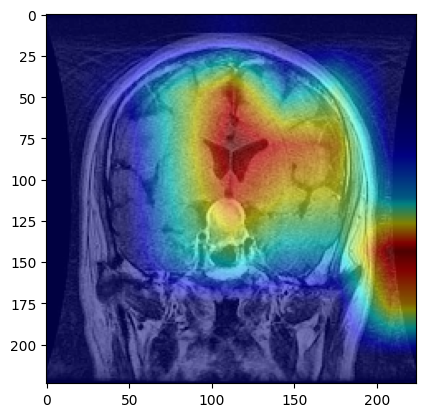

In [26]:

plt.imshow(cam_image_real)
plt.show()



In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)   # 4 classes

model_path = "/kaggle/input/classification_of_brain_tumour/pytorch/default/1/classification (1).pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dir = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Testing" 

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


class_names = test_dataset.classes
for i in range(5):
    print(f"Predicted: {class_names[all_preds[i]]}, Actual: {class_names[all_labels[i]]}")


Using: cuda
✅ Test Accuracy: 66.82%
Predicted: meningioma, Actual: glioma
Predicted: glioma, Actual: glioma
Predicted: glioma, Actual: glioma
Predicted: meningioma, Actual: glioma
Predicted: glioma, Actual: glioma


<Figure size 800x600 with 0 Axes>

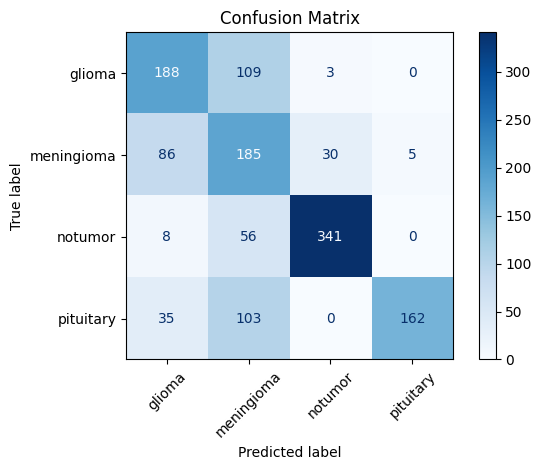

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

class_names = test_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
